# **Document** **Clustering (KMeans)**

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re

from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import nltk

In [2]:
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
class clustering:


    def tf_idf_vectorizer(self, facts_df):
        # Vectorise
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
        # Matrix of vectors that will be used to train KMeans
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        return vectorizer, matrix

    # (Mainly for experiments) Used to understand inertia without first applying dimensionality reduction
    def calculate_inertia(self, facts_df, end, step):
        #tf-idf
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.20, ngram_range=(2,2))
        matrix = vectorizer.fit_transform(facts_df['Facts'])

        # save k-means inertia for each K used to train the model
        inertia_list = []
        for k in range(1,end, step):
          kmeans = KMeans(n_clusters=k, random_state=42)
          kmeans.fit(matrix)
          inertia_list.append(kmeans.inertia_)

        return inertia_list


    # This function is to calculate inertia when SVD is applied, inertia_list used for plotting
    def calc_inertia_svd(self, X_svd, end, step):
      inertia_list = []
      for k in range(1,end, step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_svd)
        inertia_list.append(kmeans.inertia_)

      return inertia_list

    # This function is to plot the scatter plots of Violation/Non-Violation processed facts
    def view_k_means(self, facts_df, kmeans):

        kmeans.fit(matrix)
        clusters = kmeans.labels_

        # Visualisation
        pca = PCA(n_components=2, random_state=42)
        pca_vecs = pca.fit_transform(matrix.toarray())
        x0 = pca_vecs[:, 0]
        x1 = pca_vecs[:, 1]
        facts_df['Cluster'] = clusters
        facts_df['x0'] = x0
        facts_df['x1'] = x1

        # getting the top keywords
        top_words = pd.DataFrame(matrix.todense()).groupby(clusters).mean()
        terms = vectorizer.get_feature_names_out()
        for i,r in top_words.iterrows():
            print('\nCluster {}'.format(i))
            print(','.join([terms[t] for t in np.argsort(r)[-10:]]))


        cluster_map = {0: 'Private Life',
                        1: 'Injury',
                        2: 'Prisoner',
                        3: 'Confinement',
                        4:'Defamation'}


        facts_df['Cluster'] = facts_df['Cluster'].map(cluster_map)


        # set image size
        plt.figure(figsize=(12, 7))
        # set a title
        plt.title("Processed Non-Violation Facts - Document clustering", fontdict={"fontsize": 18})
        # set axes names
        plt.xlabel("X0", fontdict={"fontsize": 16})
        plt.ylabel("X1", fontdict={"fontsize": 16})
        # create scatter plot with seaborn, where hue is the class used to group the data
        sns.scatterplot(data=facts_df, x='x0', y='x1', hue='Cluster', palette="Paired", s = 50)
        plt.show()


## Importing all files

In [4]:
from google.colab import files
import io
uploaded = files.upload()

Saving facts_processed.csv to facts_processed.csv


In [5]:
processed = pd.read_csv(io.BytesIO(uploaded['facts_processed.csv']))

In [ ]:
v_processed = pd.read_csv(io.BytesIO(uploaded['violation_facts_processed.csv']))
v_lemma = pd.read_csv(io.BytesIO(uploaded['violation_facts_lemma.csv']))
v_sw = pd.read_csv(io.BytesIO(uploaded['violation_facts_sw.csv']))
v_none = pd.read_csv(io.BytesIO(uploaded['violation_facts_none.csv']))

Some more pre-processing (Removing non-english words and words that have less than three letters)

In [6]:
all_processed_facts = processed

In [27]:
clusters = clustering()

In [8]:
print(all_processed_facts['Facts'])

0       born life vilnius around motorcycle collided c...
1       introduction lived worked farmer village kuşko...
2       detail concerning found annex background oliar...
3       born life râmnicu vâlcea pretrial detention ag...
4       born life louvencourt hired french national ra...
                              ...                        
1108    born life ljubljana member supervisory board c...
1109    entity russian represented soboleva practising...
1110    background information first born life petersb...
1111    company limited liability company owner greek ...
1112    born currently serving prison detention instit...
Name: Facts, Length: 1113, dtype: object


In [9]:
def remove_lang_words(facts_words, english_words):
  # Filtering out non-english words and three letter words
  filtered = [word for word in facts_words if word in english_words and len(word)>3]
  return filtered

In [10]:
new_facts = pd.DataFrame(columns=['Facts'])
english_words = set(nltk.corpus.words.words())

for fact in all_processed_facts['Facts']:
  fact_words = fact.split()
  facts_words_filtered = remove_lang_words(fact_words, english_words)
  new_fact = ' '.join(facts_words_filtered)
  new_row = pd.DataFrame({'Facts': [new_fact]})
  new_facts = pd.concat([new_facts, new_row], ignore_index=True)

new_facts.head()

,Facts
0,born life around motorcycle driven residential...
1,introduction lived worked farmer village close...
2,detail concerning found annex background stabl...
3,born life detention aged detention hour follow...
4,born life hired national railway company last ...


In [11]:
len(new_facts)

1113

PCA applied by means of the Singular Value Decomposition (SVD)

In [12]:
vectorizer, matrix = clusters.tf_idf_vectorizer(new_facts)

In [15]:
svd = TruncatedSVD(n_components = 500, random_state = 42)
X_svd = svd.fit_transform(matrix)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.75


In [16]:
X_svd.shape

(1113, 500)

In [17]:
import warnings
warnings.filterwarnings('ignore')

Plotting the inertia-curve to figure out the optimal number of clusters (this example is for non-violation processed facts where K=8)

Text(0.5, 1.0, 'Calculating Inertia for K Clusters')

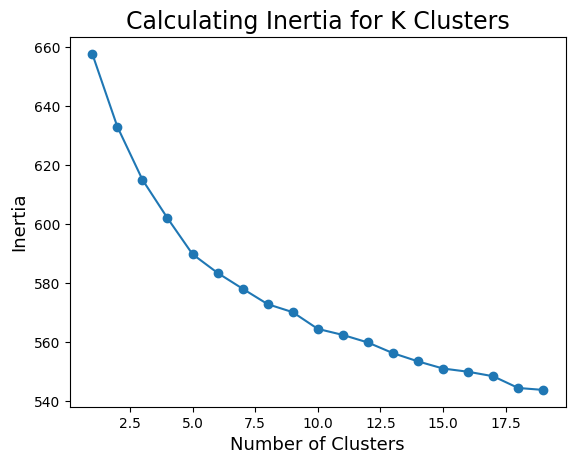

In [18]:
inertia_list = clusters.calc_inertia_svd(X_svd, 20, 1)
plt.plot(range(1,20, 1),inertia_list)
plt.scatter(range(1,20, 1),inertia_list)
#plt.scatter(8, inertia_list[8], marker="X", s=300, c="r")

plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia", size=13)
plt.title("Calculating Inertia for K Clusters", size=17)

### K Clusters - Svd - Silhouette Experiment
To backup the results obtained from the Inertia-Curve by calculating the silhouette score for each K.

In [ ]:
best_combination = pd.DataFrame(columns= ['K', 'SVD', 'Var', 'Silhouette'])
k_list = []
components_list = []
variance_list = []
silhouette_list = []
max_sil = -2
for k in range(4, 50):
  #for components in range(1, len(new_facts), 5):
  svd = TruncatedSVD(n_components = 140, random_state = 42)
  X_svd = svd.fit_transform(matrix)

  k_means = KMeans(n_clusters=k, random_state=42)
  in_y_pred = k_means.fit_predict(X_svd)
  silhouette_avg = silhouette_score(X_svd, in_y_pred)

  if max_sil < silhouette_avg:
    max_sil = silhouette_avg

  k_list.append(k)
  components_list.append(140)
  variance_list.append(np.sum(svd.explained_variance_ratio_))
  silhouette_list.append(silhouette_avg)


best_combination['K'] = k_list
best_combination['SVD'] = components_list
best_combination['Var'] = variance_list
best_combination['Silhouette'] = silhouette_list

print(max_sil)
best_combination.head()

0.10363451546482903


,K,SVD,Var,Silhouette
0,4,140,0.706181,0.006374
1,5,140,0.706181,0.027540
2,6,140,0.706181,0.014314
3,7,140,0.706181,0.024445
4,8,140,0.706181,0.030629


In [ ]:
best_combination

,K,SVD,Var,Silhouette
0,4,140,0.706181,0.006374
1,5,140,0.706181,0.027540
2,6,140,0.706181,0.014314
3,7,140,0.706181,0.024445
4,8,140,0.706181,0.030629
5,9,140,0.706181,0.025444
6,10,140,0.706181,0.040244
7,11,140,0.706181,0.032462
8,12,140,0.706181,0.037515
9,13,140,0.706181,0.032102


## Word Clouds
Showing the top 100 (tf-idf) words for each cluster. Visualisation method used is Word Clouds, plotting code provided by: https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial


In [19]:
def word_cloud_generator(X, in_X_tfidf, k, in_word_positions):
  # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_cluster_ids, in_model

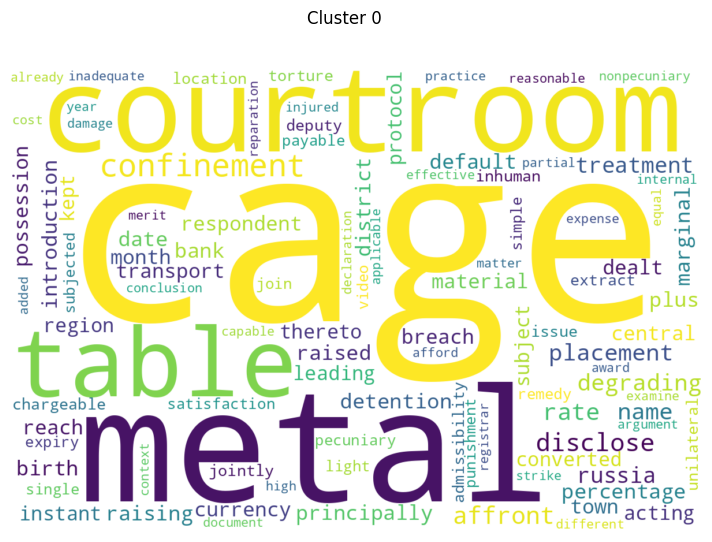

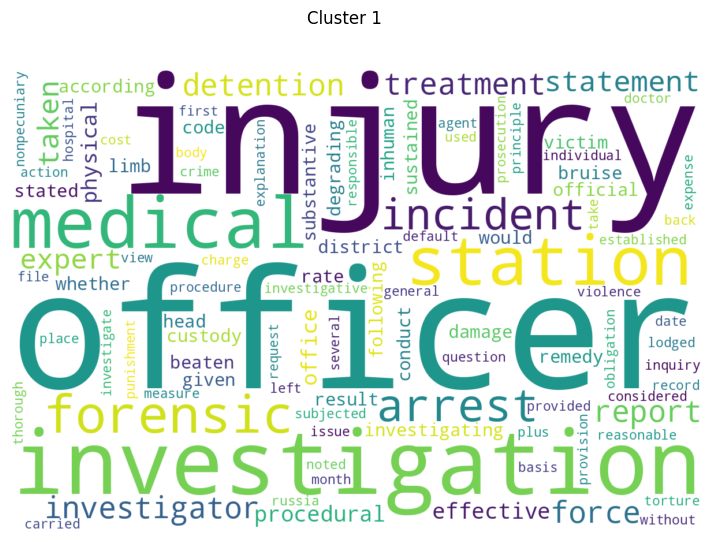

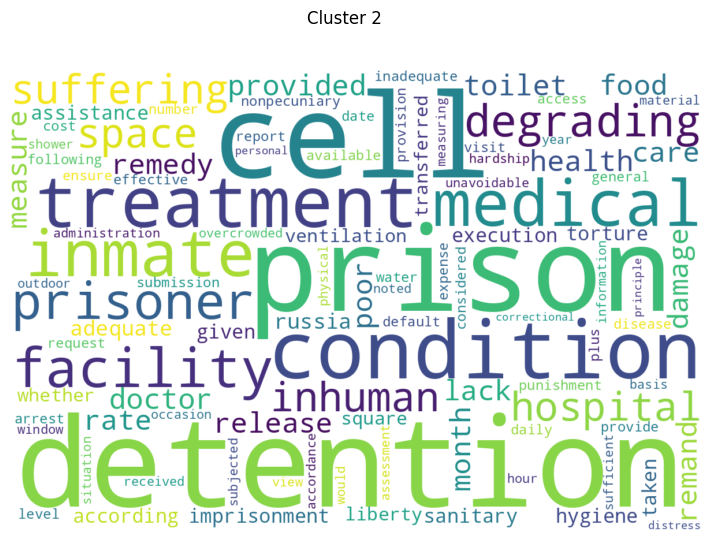

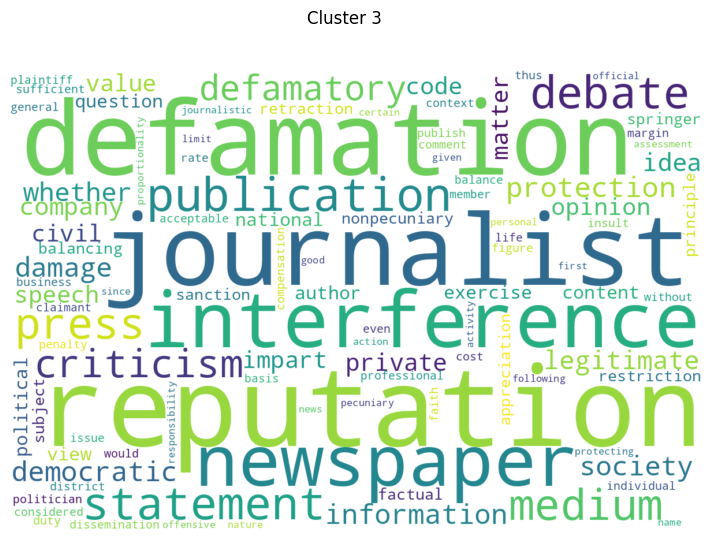

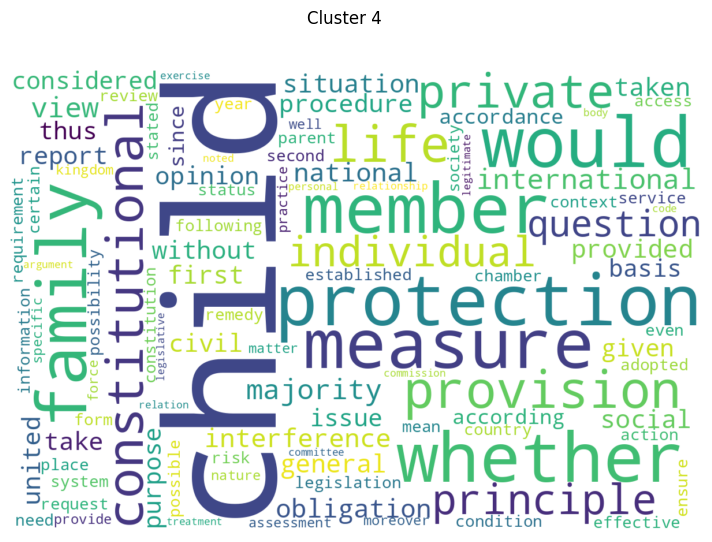

In [20]:
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
cluster_ids, kmeans = word_cloud_generator(X_svd, matrix, 5, word_positions)

### Another visualisation method: Scatter plot


Cluster 0
private,family,provision,constitutional,whether,member,measure,would,child,protection

Cluster 1
detention,investigator,treatment,arrest,forensic,station,medical,investigation,injury,officer

Cluster 2
degrading,prisoner,medical,facility,treatment,inmate,condition,prison,cell,detention

Cluster 3
name,degrading,rate,affront,disclose,confinement,table,courtroom,metal,cage

Cluster 4
criticism,press,debate,statement,publication,newspaper,interference,journalist,defamation,reputation


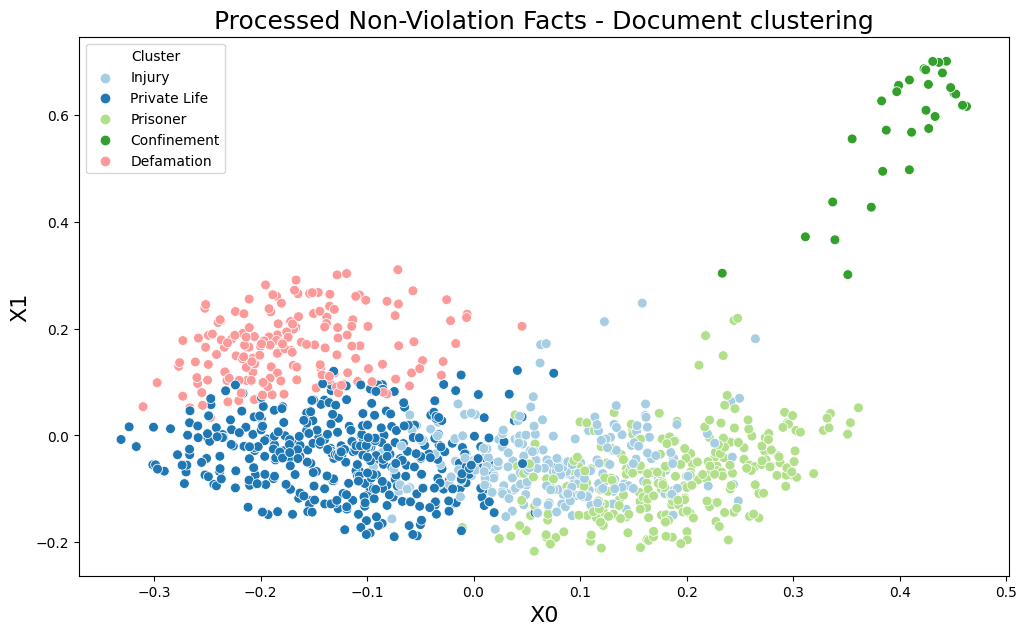

In [28]:
clusters.view_k_means(all_processed_facts, kmeans)